# 【Jax NumPyro vs PyTorch Pyro】階層ベイズモデルMCMC対決
https://www.hellocybernetics.tech/entry/2020/02/18/184406

In [1]:
import pandas as pd
df = pd.read_csv("ice.csv")
df.head(3)

,temparature,weather,sells
0,35.248615,0,132.44
1,37.528355,0,142.51
2,32.518875,0,127.70


Text(0, 0.5, 'sells')

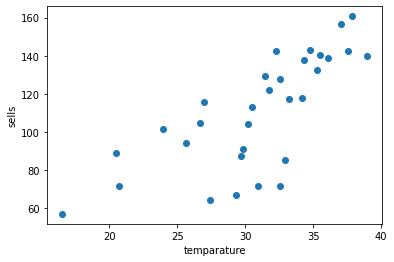

In [2]:
import matplotlib.pyplot as plt
plt.scatter(df["temparature"], df["sells"])
plt.xlabel("temparature")
plt.ylabel("sells")

気温と売上に相関ありそう

気温と天気をパラメータにして回帰モデル作る

In [3]:
temp_data = df["temparature"].values
weather_data = df["weather"].values
sells_data = df["sells"].values

In [4]:
from jax import random
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

In [5]:
# GPUだとMCMC遅いのでcpu使う
numpyro.set_platform("cpu")

In [6]:
def model(temp_obs, weather_obs, sells_obs):

    temp_means = numpyro.sample(
        "temp_means", 
        dist.Normal(loc=jnp.array(30.),
                    scale=jnp.array(2.0)),
    )
    temp_stds = numpyro.sample(
        "temp_stds", 
        dist.LogNormal(loc=jnp.array(0.),
                       scale=jnp.array(2.)),
    )

    sells_std = numpyro.sample(
        "sells_std", 
        dist.LogNormal(loc=jnp.array([0., 0.]),
                    scale=jnp.array([5.0, 5.0])),
    )

    with numpyro.plate("temps_", 2):
        temps = numpyro.sample(
            "temps",
            dist.Normal(temp_means, temp_stds),
        )
    
    temp_coeff = numpyro.sample("temp_coeff",
                        dist.Normal(jnp.array([0., 0.]), jnp.array([1., 1.])),
                        )
    temp_bias = numpyro.sample("temp_bias",
                       dist.Normal(jnp.array([0., 0.]), jnp.array([100., 100.])),
                       )
    weather_prob = numpyro.sample("weather_prob",
                         dist.Beta(1.0, 1.0),
                         )

    with numpyro.plate("days", size=len(temp_data)):
        weather = numpyro.sample(
            "weather", 
            dist.Bernoulli(probs=weather_prob),
            obs=weather_obs,
        ).astype(jnp.int32)

        temp = numpyro.sample(
            "temp", 
            dist.Normal(loc=temps[weather], scale=temp_stds),
            obs=temp_obs,
        )

        sells = numpyro.sample(
            "sells",
            dist.Normal(loc=temp_coeff[weather] * temp + temp_bias[weather], 
                           scale=sells_std[weather]),
            obs=sells_obs,
        )
    return temp, weather, sells

In [7]:
mcmc = MCMC(NUTS(model, max_tree_depth=10), 
            num_warmup=200, 
            num_samples=1000, progress_bar=True,)
mcmc.run(random.PRNGKey(2019), temp_data, weather_data, sells_data)

sample: 100%|██████████████████████████████████████| 1200/1200 [00:02<00:00, 421.75it/s, 31 steps of size 9.52e-02. acc. prob=0.92]


In [8]:
samples = mcmc.get_samples()

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


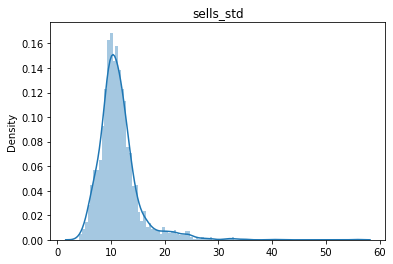

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


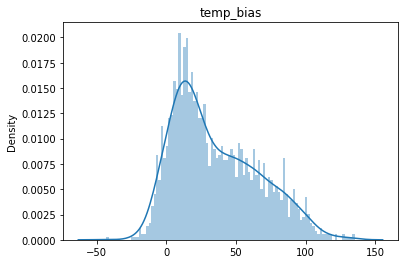

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


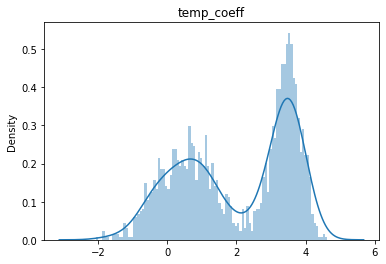

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


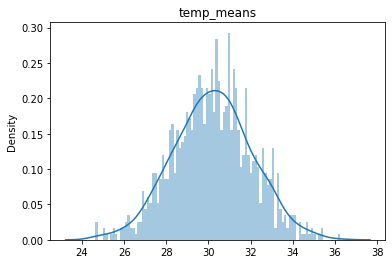

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


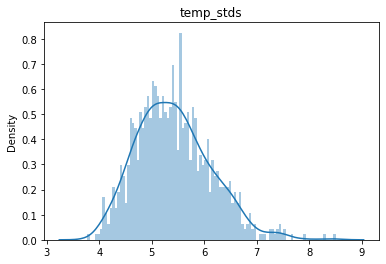

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


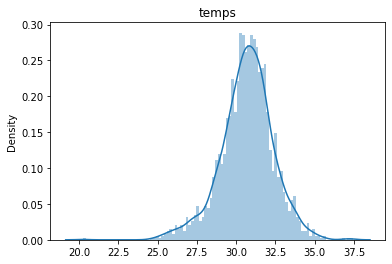

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


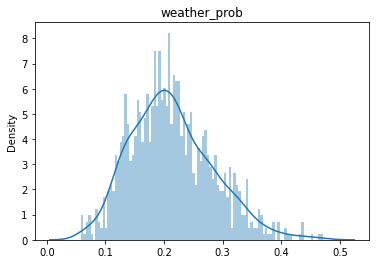

In [9]:
import seaborn as sns
for k in samples.keys():
    sns.distplot(samples[f"{k}"], bins=100).set_title(f"{k}")
    plt.show()

In [10]:
samples

{'sells_std': DeviceArray([[11.849625, 22.968605],
              [13.852763, 18.707447],
              [13.016952, 18.126982],
              ...,
              [ 8.871449,  8.663529],
              [ 8.226841, 12.001937],
              [ 8.512651, 11.780869]], dtype=float32),
 'temp_bias': DeviceArray([[ 19.3331  , 109.816124],
              [  6.670024,  72.81642 ],
              [  9.372497,  87.401375],
              ...,
              [  5.100357,  26.601477],
              [ 14.483129,  19.53086 ],
              [ 11.859838,  23.050095]], dtype=float32),
 'temp_coeff': DeviceArray([[ 3.3595834 , -0.37450802],
              [ 3.737572  , -0.59817994],
              [ 3.6256256 ,  0.1403512 ],
              ...,
              [ 3.7654517 ,  1.6826799 ],
              [ 3.4256184 ,  1.7103404 ],
              [ 3.5069263 ,  1.925586  ]], dtype=float32),
 'temp_means': DeviceArray([27.63999 , 31.935867, 31.324203, 28.305632, 31.541033,
              30.305267, 30.34269 , 31.994577, 31